# setup

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# prediction

In [4]:
import keras.backend as  K
from keras.models import model_from_json
import skimage.io as io
from model_unet import create_unet
from train_resnet import create_resunet

with K.tf.device('/cpu:0'):
    #model = create_unet((512, 512, 3), 64, "binarize")
    #model.load_weights("./data/2017-04-28-11-11-28_fil64_adam_lr0.0001_glorot_uniform_dice_coef_weights.epoch0081-val_loss-0.75-val_dice_coef0.75.hdf5") # ancient
    #model.load_weights("./data/2017-05-17-07-58-54_float32_binarize_fil64_adam_lr0.0001_glorot_uniform_shape512x512_batch_size8_weights.epoch0046-val_loss-0.77-val_dice_coef0.77.hdf5") # 復元モデル
    
    model = create_resunet((512, 512, 3), mode="sigmoid")
    model.load_weights("./data/2017-05-26-06-13-47_float32_resnet-mask_weights.epoch0107-val_loss-0.83-val_dice_coef0.83.hdf5")
    
    model2 = create_unet((512, 512, 4), 64, "heatmap")
    model2.load_weights("./data/2017-05-12-06-02-02_fil64_adam_lr0.0001_glorot_uniform_shape256x256_learn_head_data_aug_mean_squared_error_weights.epoch0081-val_loss129.64-val_acc0.71.hdf5")
    
    #model3 = create_unet((512, 512, 3), 64, "hydra")
    #model3.load_weights("./data/2017-05-17-07-36-40_float32_hydra_fil64_adam_lr0.0001_glorot_uniform_shape512x512_batch_size8_data_aug_weights.epoch0048-val_loss-0.77.hdf5")
    


(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)
(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)
(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)
(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)
(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)
(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)
(1, 256, 256) (1, 512, 512, 3) (512, 512)
(1, 512, 512, 4)


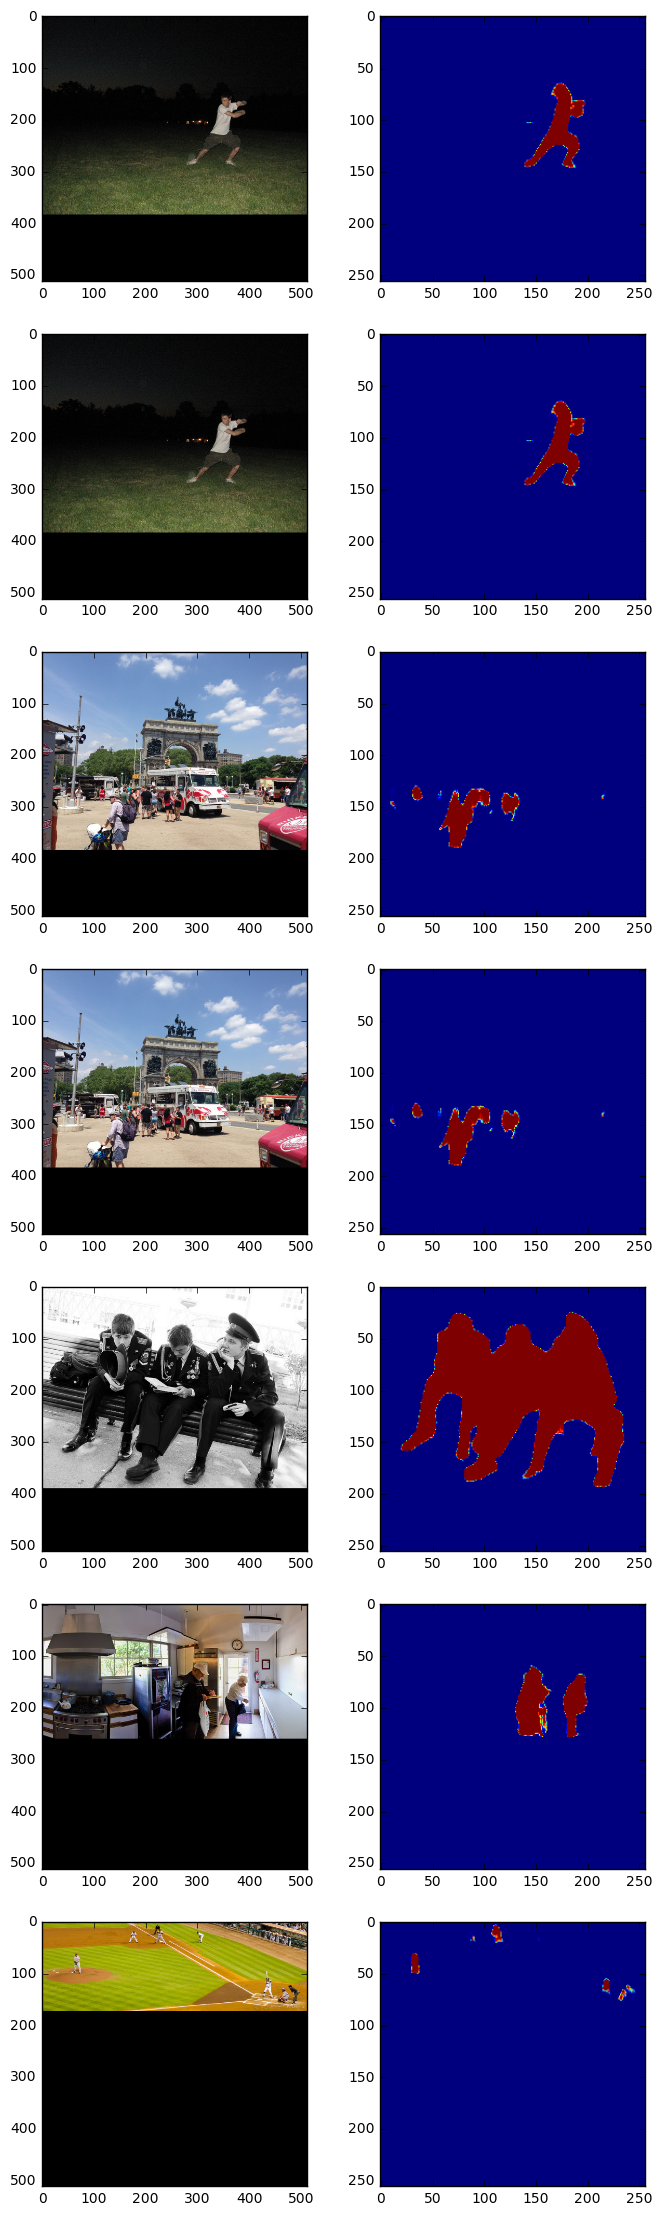

In [7]:
def trims(lines: str)-> List[str]: return [line.strip() for line in lines.split("\n") if line != ""]
from PIL import Image
def wrap(img, dest_width, dest_height, randX, randY):
    if img.ndim > 2:
        ch = img.shape[2]
        dest = np.zeros((dest_width, dest_height, ch), dtype="uint8")
    else:
        dest = np.zeros((dest_width, dest_height), dtype="uint8")
    height = img.shape[0]
    width = img.shape[1]
    if width<height:
            dest_width = int(dest_height/height * width)
    elif width>height:
            dest_height = int(dest_width/width * height)
    img = cv2.resize(img, (dest_width, dest_height))
    rangeX = max(0, dest.shape[1] - img.shape[1])
    rangeY = max(0, dest.shape[0] - img.shape[0])
    _img = Image.fromarray(img)
    _dest = Image.fromarray(dest)
    _dest.paste(_img, (int(rangeX*randX), int(rangeY*randY)))
    dest = np.asarray(_dest)
    dest.flags.writeable = True
    return dest

'''
https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Sanzio_01_Plato_Aristotle.jpg/800px-Sanzio_01_Plato_Aristotle.jpg
https://upload.wikimedia.org/wikipedia/commons/6/6d/Cloud_Team.jpg
https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Christ_Pantocrator_Deesis_mosaic_Hagia_Sophia.jpg/800px-Christ_Pantocrator_Deesis_mosaic_Hagia_Sophia.jpg
'''
img_names = trims('''
./data/val2014/COCO_val2014_000000000589.jpg
./data/val2014/COCO_val2014_000000000139.jpg
./data/val2014/COCO_val2014_000000000257.jpg
./data/val2014/COCO_val2014_000000000283.jpg
./data/val2014/COCO_val2014_000000000328.jpg
./data/val2014/COCO_val2014_000000000338.jpg
./data/val2014/COCO_val2014_000000000357.jpg
''')


mtx = []
with K.tf.device('/cpu:0'):
    for name in img_names:
        img = io.imread(name)
        img  = wrap(img, 512, 512, 0, 0) 
        img = np.expand_dims(img, axis=0)

        output = model.predict(img)
        resized = cv2.resize(output[0], (512, 512))
        print(output.shape, img.shape, resized.shape)
        img2 = np.dstack((img[0], resized))
        img2 = np.expand_dims(img2, axis=0)
        print(img2.shape)
        output2 = model2.predict(img2)
        th1 = (output2[0]/output2[0].max()*255).astype("uint8")
        th1[th1 < 128] = 0
        labelnum, labelimg, contours, GoCs = cv2.connectedComponentsWithStats(th1)
        for label in range(labelnum):
            x,y,w,h,size = contours[label]
            if w == 512 and h == 512: continue
            if size < 5*5: continue
            marginX = int(w/2)
            marginY = int(h/2)
            startY = max(0, y-marginY)
            stopY = min(y+h+marginY, 511)
            startX = max(0, x-marginX)
            stopX = min(x+w+marginX, 511)
            rect = th1[startY:stopY, startX:stopX]
            if rect.max() < 192: continue
            th1 = cv2.rectangle(th1, (startX,startY), (stopX,stopY), (128,128,128), 1)
            row = [
                (lambda img: lambda x: plt.imshow(img))(img[0]),
                (lambda img: lambda x: plt.imshow(img))(output[0]),
                #(lambda img: lambda x: plt.imshow(img))(output2[0]),
                #(lambda img: lambda x: plt.imshow(img))(th1)
            ]
        mtx.append(row)

mtx_plot(mtx, ratio=(4,4))
